# Neural Network-Based Language Model for Next Token Prediction

### Data Loading And Cleaning

In [65]:
import json
import pandas as pd

# Load English (alpaca_cleaned.json) and Assamese datasets (Assamese.json)
def load_data(english_path, assamese_path):
    with open(english_path, 'r') as f:
        english_data = json.load(f)
    
    with open(assamese_path, 'r') as f:
        assamese_data = json.load(f)
    
    return english_data, assamese_data

# Clean and extract the required data
def prepare_data(english_data, assamese_data, sample_size=50):
    # Take the first 50 examples from each dataset for training
    train_english = english_data[:sample_size]
    train_assamese = assamese_data[:sample_size]
    
    # Take the last 50 examples from each dataset for validation
    val_english = english_data[-sample_size:]
    val_assamese = assamese_data[-sample_size:]
    
    # Merge training and validation datasets
    train_data = train_english + train_assamese
    val_data = val_english + val_assamese
    
    return train_data, val_data

# Paths to data files
english_path = 'alpaca_cleaned.json'
assamese_path = 'Assamese.json'

# Load and prepare the data
english_data, assamese_data = load_data(english_path, assamese_path)
train_data, val_data = prepare_data(english_data, assamese_data)

# Display sample sizes
print(f'Training data size: {len(train_data)}')
print(f'Validation data size: {len(val_data)}')


Training data size: 100
Validation data size: 100


# GP-2 Tokenizer

In [24]:
 from transformers import GPT2Tokenizer

# Load GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Add padding tokens to the tokenizer
tokenizer.pad_token = tokenizer.eos_token

# Function to tokenize a dataset
def tokenize_data(data, tokenizer, max_length=512):
    inputs = []
    outputs = []
    
    for entry in data:
        instruction = entry.get('instruction', '')
        input_text = entry.get('input', '')
        output_text = entry.get('output', '')
        
        # Combine instruction and input for tokenization
        combined_input = instruction + " " + input_text
        tokenized_input = tokenizer(combined_input, truncation=True, padding='max_length', max_length=max_length)
        tokenized_output = tokenizer(output_text, truncation=True, padding='max_length', max_length=max_length)
        
        inputs.append(tokenized_input['input_ids'])
        outputs.append(tokenized_output['input_ids'])
    
    return inputs, outputs

# Tokenize training and validation data
train_inputs, train_outputs = tokenize_data(train_data, tokenizer)
val_inputs, val_outputs = tokenize_data(val_data, tokenizer)

print(f"Tokenized train data size: {len(train_inputs)}")
print(f"Tokenized validation data size: {len(val_inputs)}")


Tokenized train data size: 100
Tokenized validation data size: 100


/opt/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Embedding and LSTM Model Building

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Neural Network model for next-token prediction
class NextTokenModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(NextTokenModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x):
        x = self.embedding(x)
        rnn_out, _ = self.rnn(x)
        logits = self.fc(rnn_out)
        return logits

# Create model
vocab_size = tokenizer.vocab_size
embedding_dim = 256
hidden_dim = 512

model = NextTokenModel(vocab_size, embedding_dim, hidden_dim)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


NextTokenModel(
  (embedding): Embedding(50257, 256)
  (rnn): GRU(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=50257, bias=True)
)

# Training and losses

Epoch 1, Train Loss: 7.73902153968811, Val Loss: 6.2885777950286865
Epoch 2, Train Loss: 3.731250762939453, Val Loss: 4.852449059486389
Checkpoint saved at checkpoint_epoch_2.pth
Epoch 3, Train Loss: 3.6915414333343506, Val Loss: 3.8921849131584167
Epoch 4, Train Loss: 2.490002751350403, Val Loss: 3.1142460107803345
Checkpoint saved at checkpoint_epoch_4.pth
Epoch 5, Train Loss: 2.497803032398224, Val Loss: 2.928856372833252
Epoch 6, Train Loss: 2.306287258863449, Val Loss: 2.9287983775138855
Checkpoint saved at checkpoint_epoch_6.pth
Epoch 7, Train Loss: 2.338519275188446, Val Loss: 3.0046048164367676
Epoch 8, Train Loss: 2.1667630076408386, Val Loss: 2.9524718821048737
Checkpoint saved at checkpoint_epoch_8.pth
Epoch 9, Train Loss: 2.4194843769073486, Val Loss: 2.948956310749054
Epoch 10, Train Loss: 2.283351480960846, Val Loss: 2.934361010789871
Checkpoint saved at checkpoint_epoch_10.pth


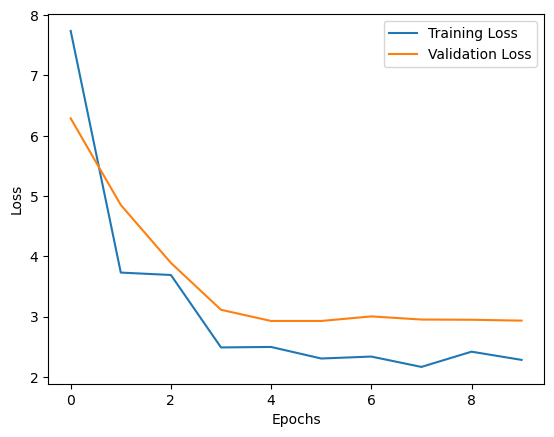

In [28]:
 import matplotlib.pyplot as plt

# Create dataloaders
train_dataset = TensorDataset(torch.tensor(train_inputs), torch.tensor(train_outputs))
val_dataset = TensorDataset(torch.tensor(val_inputs), torch.tensor(val_outputs))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Training function
def train(model, train_loader, val_loader, criterion, optimizer, epochs=10, checkpoint_interval=2):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Reshape outputs for loss calculation
            loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")
        
        # Checkpoint saving
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = f'checkpoint_epoch_{epoch+1}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved at {checkpoint_path}")
    
    return train_losses, val_losses

# Train the model
train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, epochs=10)

# Plotting the loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_curve.png')
plt.show()

# Save the losses in a CSV file
loss_df = pd.DataFrame({'Epoch': range(1, 11), 'Train Loss': train_losses, 'Validation Loss': val_losses})
loss_df.to_csv('losses.csv', index=False)


# Next Token Prediction

In [34]:
import torch.nn.functional as F

# Function to generate text from the model
def generate_text_custom(model, tokenizer, prompt, max_length=50):
    model.eval()
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    
    generated_tokens = input_ids.tolist()[0]  # Start with the input prompt
    
    # Manually generate tokens one by one
    for _ in range(max_length):
        # Convert current tokens to tensor
        input_tensor = torch.tensor([generated_tokens]).to(device)
        
        # Get the model's output (logits)
        with torch.no_grad():
            logits = model(input_tensor)
        
        # Take the logits for the last token and apply softmax to get probabilities
        next_token_logits = logits[0, -1, :]
        next_token_probs = F.softmax(next_token_logits, dim=-1)
        
        # Sample the next token (or take the argmax for greedy decoding)
        next_token = torch.argmax(next_token_probs).item()
        
        # Add the predicted token to the sequence
        generated_tokens.append(next_token)
        
        # Stop if the model generates the end-of-sequence token
        if next_token == tokenizer.eos_token_id:
            break
    
    # Decode the generated tokens back into text
    generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
    return generated_text

# Generate output from randomly initialized model
random_model_output = generate_text_custom(model, tokenizer, prompt="Hello world", max_length=50)
print("Random Model Output:", random_model_output)

# Load trained model's checkpoint
model.load_state_dict(torch.load('checkpoint_epoch_10.pth'))  # Load the final checkpoint

# Generate output from the trained model
trained_model_output = generate_text_custom(model, tokenizer, prompt="Hello world", max_length=50)
print("Trained Model Output:", trained_model_output)

# Generate output in Assamese
assamese_prompt = "Give three tips for staying healthy."
assamese_output = generate_text_custom(model, tokenizer, prompt=assamese_prompt, max_length=50)
print("Assamese Model Output:", assamese_output)

# Use Google Translate manually to translate Assamese to English


Random Model Output: Hello world England ax���������������


/var/folders/fx/vbj5djls49z6lsrd_27sfk900000gn/T/ipykernel_2184/266914567.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint_e

Trained Model Output: Hello world England ax���������������
Assamese Model Output: Give three tips for staying healthy. nutritious nutritious withheld shaft Fight anarchistulate alludedtype revertedpendulate��


In [79]:
import torch.nn.functional as F

# Function to generate text from the model
def generate_text_custom(model, tokenizer, prompt, max_length=50):
    model.eval()
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    
    generated_tokens = input_ids.tolist()[0]  # Start with the input prompt
    
    # Manually generate tokens one by one
    for _ in range(max_length):
        # Convert current tokens to tensor
        input_tensor = torch.tensor([generated_tokens]).to(device)
        
        # Get the model's output (logits)
        with torch.no_grad():
            logits = model(input_tensor)
        
        # Take the logits for the last token and apply softmax to get probabilities
        next_token_logits = logits[0, -1, :]
        next_token_probs = F.softmax(next_token_logits, dim=-1)
        
        # Sample the next token (or take the argmax for greedy decoding)
        next_token = torch.argmax(next_token_probs).item()
        
        # Add the predicted token to the sequence
        generated_tokens.append(next_token)
        
        # Stop if the model generates the end-of-sequence token
        if next_token == tokenizer.eos_token_id:
            break
    
    # Decode the generated tokens back into text
    generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
    return generated_text

# Generate output from randomly initialized model
random_model_output = generate_text_custom(model, tokenizer, prompt="Hello world", max_length=50)
print("Random Model Output:", random_model_output)

# Load trained model's checkpoint
model.load_state_dict(torch.load('checkpoint_epoch_10.pth'))  # Load the final checkpoint

# Generate output from the trained model
trained_model_output = generate_text_custom(model, tokenizer, prompt="Hello world", max_length=50)
print("Trained Model Output:", trained_model_output)

# Generate output in Assamese
assamese_prompt = "Give three tips for staying healthy."
assamese_output = generate_text_custom(model, tokenizer, prompt=assamese_prompt, max_length=50)
print("Assamese Model Output:", assamese_output)

# Use Google Translate manually to translate Assamese to English

Random Model Output: Hello world England ax���������������


/var/folders/fx/vbj5djls49z6lsrd_27sfk900000gn/T/ipykernel_2184/436038338.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint_e

Trained Model Output: Hello world England ax���������������
Assamese Model Output: Give three tips for staying healthy. nutritious nutritious withheld shaft Fight anarchistulate alludedtype revertedpendulate��
